In [23]:
import random
from os.path import exists
from tensorflow.keras.optimizers import Adam
from scipy.stats import entropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow as tf
import matplotlib.pyplot as plt
from src.datasets.load_ascadr import *
from src.datasets.load_ascadf import *
from src.datasets.load_dpav42 import *
from src.datasets.load_eshard import *
from src.datasets.load_chesctf import *

tf.keras.backend.set_floatx('float64')

In [24]:
dataset_root_path = "D:/traces"
results_root_path = "D:/postdoc/paper_cgan_features"
features_root_path = "D:/postdoc/paper_cgan_features/cgan_reference_features"

In [25]:
dataset_reference_name = "ascad-variable"
dataset_target_name = "ASCAD"
dataset_reference_path = f"{dataset_root_path}/ASCADr/ascad-variable_nopoi/ascad-variable_nopoi_window_20.h5"
dataset_target_path = f"{dataset_root_path}/ASCADf/ASCAD_nopoi/ASCAD_nopoi_window_20.h5"
dataset_reference_dim = 25000
dataset_target_dim = 10000
n_profiling_reference = 200000
n_attack_reference = 5000
n_profiling_target = 50000
n_validation_target = 5000
n_attack_target = 5000
n_attack_ge = 2000
target_byte_reference = 2
target_byte_target = 2
leakage_model = "ID"
cgan_epochs = 100
batch_size = 400
cgan_features = 100

In [26]:
def snr_fast(x, y):
    ns = x.shape[1]
    unique = np.unique(y)
    means = np.zeros((len(unique), ns))
    variances = np.zeros((len(unique), ns))

    for i, u in enumerate(unique):
        new_x = x[np.argwhere(y == int(u))]
        means[i] = np.mean(new_x, axis=0)
        variances[i] = np.var(new_x, axis=0)
    return np.var(means, axis=0) / np.mean(variances, axis=0)


def get_features(dataset, target_byte: int, n_poi=100):
    snr_val_share_1 = snr_fast(np.array(dataset.x_profiling, dtype=np.int16), np.asarray(dataset.share1_profiling[target_byte, :]))
    snr_val_share_2 = snr_fast(np.array(dataset.x_profiling, dtype=np.int16), np.asarray(dataset.share2_profiling[target_byte, :]))
    snr_val_share_1[np.isnan(snr_val_share_1)] = 0
    snr_val_share_2[np.isnan(snr_val_share_2)] = 0
    ind_snr_masks_poi_sm = np.argsort(snr_val_share_1)[::-1][:int(n_poi / 2)]
    ind_snr_masks_poi_sm_sorted = np.sort(ind_snr_masks_poi_sm)
    ind_snr_masks_poi_r2 = np.argsort(snr_val_share_2)[::-1][:int(n_poi / 2)]
    ind_snr_masks_poi_r2_sorted = np.sort(ind_snr_masks_poi_r2)

    poi_profiling = np.concatenate((ind_snr_masks_poi_sm_sorted, ind_snr_masks_poi_r2_sorted), axis=0)

    snr_val_share_1 = snr_fast(np.array(dataset.x_attack, dtype=np.int16), np.asarray(dataset.share1_attack[target_byte, :]))
    snr_val_share_2 = snr_fast(np.array(dataset.x_attack, dtype=np.int16), np.asarray(dataset.share2_attack[target_byte, :]))
    snr_val_share_1[np.isnan(snr_val_share_1)] = 0
    snr_val_share_2[np.isnan(snr_val_share_2)] = 0
    ind_snr_masks_poi_sm = np.argsort(snr_val_share_1)[::-1][:int(n_poi / 2)]
    ind_snr_masks_poi_sm_sorted = np.sort(ind_snr_masks_poi_sm)
    ind_snr_masks_poi_r2 = np.argsort(snr_val_share_2)[::-1][:int(n_poi / 2)]
    ind_snr_masks_poi_r2_sorted = np.sort(ind_snr_masks_poi_r2)

    poi_attack = np.concatenate((ind_snr_masks_poi_sm_sorted, ind_snr_masks_poi_r2_sorted), axis=0)

    return dataset.x_profiling[:, poi_profiling], dataset.x_attack[:, poi_attack]


def load_dataset(identifier, dataset_file, target_byte, traces_dim, n_prof, n_val, n_attack, reference=False):
    implement_reference_feature_selection = False
    reference_features_shortcut = ""
    if reference:
        """ If features were already computed for this dataset, target key byte,
        and leakage model, there is no need to compute it again"""
        reference_features_shortcut = f'{features_root_path}/selected_{cgan_features}_features_snr_{dataset_reference_name}_{dataset_reference_dim}_target_byte_{target_byte_reference}.h5'
        if exists(reference_features_shortcut):
            print("Reference features already created.")
            dataset_file = reference_features_shortcut
            traces_dim = cgan_features
        else:
            implement_reference_feature_selection = True

    dataset = None
    if identifier == "ascad-variable":
        dataset = ReadASCADr(n_prof, n_val, n_attack, target_byte, leakage_model, dataset_file, number_of_samples=traces_dim)
    if identifier == "ASCAD":
        dataset = ReadASCADf(n_prof, n_val, n_attack, target_byte, leakage_model, dataset_file, number_of_samples=traces_dim)
    if identifier == "eshard":
        dataset = ReadEshard(n_prof, n_val, n_attack, target_byte, leakage_model, dataset_file, number_of_samples=traces_dim)
    if identifier == "dpa_v42":
        dataset = ReadDPAV42(n_prof, n_val, n_attack, target_byte, leakage_model, dataset_file, number_of_samples=traces_dim)
    if identifier == "ches_ctf":
        dataset = ReadCHESCTF(n_prof, n_val, n_attack, target_byte, leakage_model, dataset_file, number_of_samples=traces_dim)

    if implement_reference_feature_selection:
        generate_features_h5(dataset, target_byte, reference_features_shortcut, cgan_features)
        dataset_file = reference_features_shortcut

        if identifier == "ascad-variable":
            return ReadASCADr(n_prof, n_val, n_attack, target_byte, leakage_model, dataset_file, number_of_samples=cgan_features)
        if identifier == "ASCAD":
            return ReadASCADf(n_prof, n_val, n_attack, target_byte, leakage_model, dataset_file, number_of_samples=cgan_features)
        if identifier == "eshard":
            return ReadEshard(n_prof, n_val, n_attack, target_byte, leakage_model, dataset_file, number_of_samples=cgan_features)
        if identifier == "dpa_v42":
            return ReadDPAV42(n_prof, n_val, n_attack, target_byte, leakage_model, dataset_file, number_of_samples=cgan_features)
        if identifier == "ches_ctf":
            return ReadCHESCTF(n_prof, n_val, n_attack, target_byte, leakage_model, dataset_file, number_of_samples=cgan_features)
    else:
        return dataset


def scale_dataset(prof_set, attack_set, scaler):
    prof_new = scaler.fit_transform(prof_set)
    if attack_set is not None:
        attack_new = scaler.transform(attack_set)
    else:
        attack_new = None
    return prof_new, attack_new


def generate_features_h5(dataset, target_byte, save_file_path, num_features):
    profiling_traces_rpoi, attack_traces_rpoi = get_features(dataset, target_byte, num_features)
    out_file = h5py.File(save_file_path, 'w')

    profiling_index = [n for n in range(dataset.n_profiling)]
    attack_index = [n for n in range(dataset.n_attack)]

    profiling_traces_group = out_file.create_group("Profiling_traces")
    attack_traces_group = out_file.create_group("Attack_traces")

    profiling_traces_group.create_dataset(name="traces", data=profiling_traces_rpoi, dtype=profiling_traces_rpoi.dtype)
    attack_traces_group.create_dataset(name="traces", data=attack_traces_rpoi, dtype=attack_traces_rpoi.dtype)

    metadata_type_profiling = np.dtype([("plaintext", dataset.profiling_plaintexts.dtype, (len(dataset.profiling_plaintexts[0]),)),
                                        ("key", dataset.profiling_keys.dtype, (len(dataset.profiling_keys[0]),)),
                                        ("masks", dataset.profiling_masks.dtype, (len(dataset.profiling_masks[0]),))
                                        ])
    metadata_type_attack = np.dtype([("plaintext", dataset.attack_plaintexts.dtype, (len(dataset.attack_plaintexts[0]),)),
                                     ("key", dataset.attack_keys.dtype, (len(dataset.attack_keys[0]),)),
                                     ("masks", dataset.attack_masks.dtype, (len(dataset.attack_masks[0]),))
                                     ])

    profiling_metadata = np.array(
        [(dataset.profiling_plaintexts[n], dataset.profiling_keys[n], dataset.profiling_masks[n]) for n in profiling_index],
        dtype=metadata_type_profiling)
    profiling_traces_group.create_dataset("metadata", data=profiling_metadata, dtype=metadata_type_profiling)

    attack_metadata = np.array([(dataset.attack_plaintexts[n], dataset.attack_keys[n], dataset.attack_masks[n]) for n in attack_index],
                               dtype=metadata_type_attack)
    attack_traces_group.create_dataset("metadata", data=attack_metadata, dtype=metadata_type_attack)

    out_file.flush()
    out_file.close()

In [27]:
dataset_reference = load_dataset(dataset_reference_name, dataset_reference_path, target_byte_reference, dataset_reference_dim,
                                 n_profiling_reference, 0, n_attack_reference, reference=True)
dataset_target = load_dataset(dataset_target_name, dataset_target_path, target_byte_target, dataset_target_dim,
                              n_profiling_target, n_validation_target, n_attack_target)

dataset_reference.x_profiling, dataset_reference.x_attack = scale_dataset(dataset_reference.x_profiling, dataset_reference.x_attack,
                                                                          StandardScaler())
dataset_target.x_profiling, dataset_target.x_attack = scale_dataset(dataset_target.x_profiling, dataset_target.x_attack, StandardScaler())

features_reference_profiling, features_reference_attack = dataset_reference.x_profiling, dataset_reference.x_attack

""" the following is used only for verification, not in the CGAN training """
features_target_profiling, features_target_attack = get_features(dataset_target, target_byte_target, n_poi=cgan_features)

Reference features already created.


In [28]:
def best_models_random_search(reference, target):
    hp_disc, hp_gen = {}, {}
    if reference == "ascad-variable":
        if target == "ASCAD":
            hp_disc = {
                'neurons_embed': 100, 'neurons_dropout': 200, 'layers_embed': 2, 'layers_dropout': 3, 'dropout': 0.7
            }
            hp_gen = {
                'neurons_1': 300, 'layers': 1, 'activation': 'linear'
            }
        if target == "dpa_v42":
            hp_disc = {
                'neurons_embed': 100, 'neurons_dropout': 200, 'layers_embed': 1, 'layers_dropout': 1, 'dropout': 0.8
            }
            hp_gen = {
                'neurons_1': 200, 'layers': 4, 'activation': 'linear', 'neurons_2': 200, 'neurons_3': 200, 'neurons_4': 100
            }
        if target == "ches_ctf":
            hp_disc = {
                'neurons_embed': 200, 'neurons_dropout': 200, 'layers_embed': 2, 'layers_dropout': 1, 'dropout': 0.5
            }
            hp_gen = {
                'neurons_1': 100, 'layers': 4, 'activation': 'linear', 'neurons_2': 100, 'neurons_3': 100, 'neurons_4': 100
            }
        if target == "eshard":
            hp_disc = {
                'neurons_embed': 200, 'neurons_dropout': 200, 'layers_embed': 1, 'layers_dropout': 1, 'dropout': 0.7
            }
            hp_gen = {
                'neurons_1': 500, 'layers': 3, 'activation': 'leakyrelu', 'neurons_2': 500, 'neurons_3': 100
            }
    if reference == "ASCAD":
        if target == "ascad-variable":
            hp_disc = {
                'neurons_embed': 200, 'neurons_dropout': 200, 'layers_embed': 2, 'layers_dropout': 1, 'dropout': 0.6,
            }
            hp_gen = {
                'neurons_1': 200, 'layers': 3, 'activation': 'leakyrelu', 'neurons_2': 200, 'neurons_3': 100
            }
        if target == "dpa_v42":
            hp_disc = {
                'neurons_embed': 200, 'neurons_dropout': 100, 'layers_embed': 2, 'layers_dropout': 2, 'dropout': 0.8
            }
            hp_gen = {
                'neurons_1': 300, 'layers': 2, 'activation': 'linear', 'neurons_2': 100
            }
        if target == "ches_ctf":
            hp_disc = {
                'neurons_embed': 200, 'neurons_dropout': 200, 'layers_embed': 2, 'layers_dropout': 1, 'dropout': 0.5
            }
            hp_gen = {
                'neurons_1': 100, 'layers': 4, 'activation': 'linear', 'neurons_2': 100, 'neurons_3': 100, 'neurons_4': 100
            }
        if target == "eshard":
            hp_disc = {
                'neurons_embed': 500, 'neurons_dropout': 200, 'layers_embed': 1, 'layers_dropout': 1, 'dropout': 0.7
            }
            hp_gen = {
                'neurons_1': 500, 'layers': 2, 'activation': 'selu', 'neurons_2': 400
            }
    if reference == "dpa_v42":
        if target == "ascad-variable":
            hp_disc = {
                'neurons_embed': 500, 'neurons_dropout': 100, 'layers_embed': 1, 'layers_dropout': 1, 'dropout': 0.6
            }
            hp_gen = {
                'neurons_1': 100, 'layers': 1, 'activation': 'elu'
            }
        if target == "ASCAD":
            hp_disc = {
                'neurons_embed': 100, 'neurons_dropout': 200, 'layers_embed': 1, 'layers_dropout': 1, 'dropout': 0.7
            }
            hp_gen = {
                'neurons_1': 500, 'layers': 4, 'activation': 'linear', 'neurons_2': 100, 'neurons_3': 100, 'neurons_4': 100
            }
        if target == "ches_ctf":
            hp_disc = {
                'neurons_embed': 500, 'neurons_dropout': 500, 'layers_embed': 1, 'layers_dropout': 1, 'dropout': 0.8
            }
            hp_gen = {
                'neurons_1': 100, 'layers': 1, 'activation': 'linear'
            }
        if target == "eshard":
            hp_disc = {
                'neurons_embed': 500, 'neurons_dropout': 500, 'layers_embed': 1, 'layers_dropout': 1, 'dropout': 0.6
            }
            hp_gen = {
                'neurons_1': 400, 'layers': 2, 'activation': 'selu', 'neurons_2': 300
            }
    if reference == "eshard":
        if target == "ascad-variable":
            hp_disc = {
                'neurons_embed': 200, 'neurons_dropout': 100, 'layers_embed': 1, 'layers_dropout': 1, 'dropout': 0.7
            }
            hp_gen = {
                'neurons_1': 100, 'layers': 4, 'activation': 'linear', 'neurons_2': 100, 'neurons_3': 100, 'neurons_4': 100
            }
        if target == "ASCAD":
            hp_disc = {
                'neurons_embed': 100, 'neurons_dropout': 500, 'layers_embed': 1, 'layers_dropout': 1, 'dropout': 0.6
            }
            hp_gen = {
                'neurons_1': 400, 'layers': 2, 'activation': 'linear', 'neurons_2': 300
            }
        if target == "dpa_v42":
            hp_disc = {
                'neurons_embed': 100, 'neurons_dropout': 500, 'layers_embed': 2, 'layers_dropout': 2, 'dropout': 0.8
            }
            hp_gen = {
                'neurons_1': 500, 'layers': 1, 'activation': 'linear'
            }
    return hp_disc, hp_gen


def discriminator_loss(real, fake):
    real_loss = cross_entropy_disc(tf.ones_like(real), real)
    fake_loss = cross_entropy_disc(tf.zeros_like(fake), fake)
    return real_loss + fake_loss


def generator_loss(fake):
    return cross_entropy(tf.ones_like(fake), fake)


def define_discriminator(features_dim, n_classes, hp_disc):
    # label input
    in_label = Input(shape=1)
    y = Embedding(n_classes, n_classes)(in_label)
    for l_i in range(hp_disc["layers_embed"]):
        y = Dense(hp_disc["neurons_embed"], kernel_initializer='random_normal')(y)
        y = LeakyReLU()(y)
    y = Flatten()(y)

    in_features = Input(shape=(features_dim,))

    merge = Concatenate()([y, in_features])

    x = None
    for l_i in range(hp_disc["layers_dropout"]):
        x = Dense(hp_disc["neurons_dropout"], kernel_initializer='random_normal')(merge if l_i == 0 else x)
        x = LeakyReLU()(x)
        x = Dropout(hp_disc["dropout"])(x)

    # output
    out_layer = Dense(1, activation='sigmoid')(x)

    model = Model([in_label, in_features], out_layer)
    model.summary()
    return model


# define a random generator model
def define_generator(input_dim, output_dim, hp_gen):
    in_traces = Input(shape=(input_dim,))
    x = None
    for l_i in range(hp_gen["layers"]):
        x = Dense(hp_gen[f"neurons_{l_i + 1}"],
                  activation=hp_gen["activation"] if hp_gen["activation"] != "leakyrelu" else None)(in_traces if l_i == 0 else x)
        if hp_gen["activation"] == "leakyrelu":
            x = LeakyReLU()(x)
    out_layer = Dense(output_dim, activation='linear')(x)

    model = Model([in_traces], out_layer)
    model.summary()
    return model

In [29]:
real_accuracy_metric = BinaryAccuracy()
fake_accuracy_metric = BinaryAccuracy()
cross_entropy = BinaryCrossentropy(from_logits=True)
cross_entropy_disc = BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0025, beta_1=0.5)

classes = 9 if leakage_model == "HW" else 256

hp_d, hp_g = best_models_random_search(dataset_reference_name, dataset_target_name)
# create the discriminator
discriminator = define_discriminator(cgan_features, classes, hp_d)
# create the generator
generator = define_generator(dataset_target_dim, cgan_features, hp_g)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 256)       65536       input_7[0][0]                    
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 1, 100)       25700       embedding_2[0][0]                
__________________________________________________________________________________________________
leaky_re_lu_10 (LeakyReLU)      (None, 1, 100)       0           dense_24[0][0]                   
____________________________________________________________________________________________

In [30]:
""" Metrics to assess quality of profiling attack: Max SNR, Guessing entropy, Ntraces_GE = 1, Perceived Information """
max_snr_share_1 = []
max_snr_share_2 = []

ge_cgansca = []
nt_cgansca = []
pi_cgansca = []

""" Just for plot """
x_axis_epochs = []

""" Accuracy for real and synthetic data """
real_acc = []
fake_acc = []

""" Generator and Discriminator Losses """
g_loss = []
d_loss = []

In [31]:
def generate_reference_samples(bs):
    rnd = np.random.randint(0, dataset_reference.n_profiling - bs)
    features = features_reference_profiling[rnd:rnd + bs]
    labels = dataset_reference.profiling_labels[rnd:rnd + bs]
    return [features, labels]


def generate_target_samples(bs):
    rnd = np.random.randint(0, dataset_target.n_profiling - bs)
    traces = dataset_target.x_profiling[rnd:rnd + bs]
    labels = dataset_target.profiling_labels[rnd:rnd + bs]
    return [traces, labels]

In [32]:
@tf.function
def train_step(traces_batch, label_traces, features, label_features):
    with tf.GradientTape() as disc_tape:
        fake_features = generator(traces_batch)
        real_output = discriminator([label_features, features])
        fake_output = discriminator([label_traces, fake_features])
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    with tf.GradientTape() as gen_tape:
        fake_features = generator(traces_batch)
        fake_output = discriminator([label_traces, fake_features])
        gen_loss = generator_loss(fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    fake_accuracy_metric.update_state(tf.zeros_like(fake_features), fake_output)
    real_accuracy_metric.update_state(tf.ones_like(features), real_output)

    return gen_loss, disc_loss


def compute_snr_reference_features():
    batch_size_reference = 10000

    # prepare traces from target dataset
    rnd_reference = random.randint(0, len(dataset_reference.x_profiling) - batch_size_reference)
    features_reference = features_reference_profiling[rnd_reference:rnd_reference + batch_size_reference]

    snr_reference_features_share_1 = snr_fast(features_reference,
                                              dataset_reference.share1_profiling[target_byte_reference,
                                              rnd_reference:rnd_reference + batch_size_reference])
    snr_reference_features_share_2 = snr_fast(features_reference,
                                              dataset_reference.share2_profiling[target_byte_reference,
                                              rnd_reference:rnd_reference + batch_size_reference])
    plt.title("$f_{ref}$")
    plt.plot(snr_reference_features_share_1, label="share 1")
    plt.plot(snr_reference_features_share_2, label="share 2")
    plt.xlabel("Features")
    plt.ylabel("SNR")
    plt.xlim([1, cgan_features])
    plt.show()
    plt.close()


def compute_snr_target_features(epoch, epoch_snr_step, synthetic_traces=True):
    batch_size_target = 10000

    # prepare traces from target dataset
    rnd_target = random.randint(0, len(dataset_target.x_profiling) - batch_size_target)

    if synthetic_traces:
        traces_target = dataset_target.x_profiling[rnd_target:rnd_target + batch_size_target]
        features_target = generator.predict([traces_target])
    else:
        features_target = features_target_profiling[rnd_target:rnd_target + batch_size_target]

    snr_target_features_share_1 = snr_fast(features_target,
                                           dataset_target.share1_profiling[target_byte_target,
                                           rnd_target:rnd_target + batch_size_target]).tolist()
    snr_target_features_share_2 = snr_fast(features_target,
                                           dataset_target.share2_profiling[target_byte_target,
                                           rnd_target:rnd_target + batch_size_target]).tolist()

    if synthetic_traces:
        if (epoch + 1) % epoch_snr_step == 0:
            plt.plot(snr_target_features_share_1)
            plt.plot(snr_target_features_share_2)
            plt.xlim([1, cgan_features])
            plt.title("$f_{target}$ (Synthetic)")
            plt.show()
            plt.close()
    else:
        plt.plot(snr_target_features_share_1)
        plt.plot(snr_target_features_share_2)
        plt.xlim([1, cgan_features])
        plt.title("$f_{target}$ (Real)")
        plt.show()
        plt.close()

    if synthetic_traces:
        max_snr_share_1.append(np.max(snr_target_features_share_1))
        max_snr_share_2.append(np.max(snr_target_features_share_2))
        if (epoch + 1) % epoch_snr_step == 0:
            plt.title("Max SNR $f_{target}$")
            plt.plot(max_snr_share_1, label="Max SNR Share 1")
            plt.plot(max_snr_share_2, label="Max SNR Share 2")
            plt.legend()
            plt.xlabel("Epochs")
            plt.ylabel("SNR")
            plt.show()
            plt.close()


def mlp(output_dim, number_of_samples, learning_rate=0.001):
    input_shape = (number_of_samples)
    input_layer = Input(shape=input_shape, name="input_layer")

    x = Dense(100, kernel_initializer="glorot_normal", activation="elu")(input_layer)
    x = Dense(100, kernel_initializer="glorot_normal", activation="elu")(x)
    x = Dense(100, kernel_initializer="glorot_normal", activation="elu")(x)
    x = Dense(100, kernel_initializer="glorot_normal", activation="elu")(x)

    output_layer = Dense(output_dim, activation='softmax', name=f'output')(x)

    m_model = Model(input_layer, output_layer, name='mlp_softmax')
    optimizer = Adam(learning_rate=learning_rate)
    m_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    m_model.summary()
    return m_model


def guessing_entropy(predictions, labels_guess, good_key, key_rank_attack_traces, key_rank_report_interval=1):
    """
    Function to compute Guessing Entropy
    - this function computes a list of key candidates, ordered by their probability of being the correct key
    - if this function returns final_ge=1, it means that the correct key is actually indicated as the most likely one.
    - if this function returns final_ge=256, it means that the correct key is actually indicated as the least likely one.
    - if this function returns final_ge close to 128, it means that the attack is wrong and the model is simply returing a random key.

    :return
    - final_ge: the guessing entropy of the correct key
    - guessing_entropy: a vector indicating the value 'final_ge' with respect to the number of processed attack measurements
    - number_of_measurements_for_ge_1: the number of processed attack measurements necessary to reach final_ge = 1
    """

    nt = len(predictions)

    key_rank_executions = 40

    # key_ranking_sum = np.zeros(key_rank_attack_traces)
    key_ranking_sum = np.zeros(
        int(key_rank_attack_traces / key_rank_report_interval))

    predictions = np.log(predictions + 1e-36)

    probabilities_kg_all_traces = np.zeros((nt, 256))
    for index in range(nt):
        probabilities_kg_all_traces[index] = predictions[index][
            np.asarray([int(leakage[index])
                        for leakage in labels_guess[:]])
        ]

    for run in range(key_rank_executions):
        r = np.random.choice(
            range(nt), key_rank_attack_traces, replace=False)
        probabilities_kg_all_traces_shuffled = probabilities_kg_all_traces[r]
        key_probabilities = np.zeros(256)

        kr_count = 0
        for index in range(key_rank_attack_traces):

            key_probabilities += probabilities_kg_all_traces_shuffled[index]
            key_probabilities_sorted = np.argsort(key_probabilities)[::-1]

            if (index + 1) % key_rank_report_interval == 0:
                key_ranking_good_key = list(
                    key_probabilities_sorted).index(good_key) + 1
                key_ranking_sum[kr_count] += key_ranking_good_key
                kr_count += 1

    ge = key_ranking_sum / key_rank_executions

    number_of_measurements_for_ge_1 = key_rank_attack_traces
    if ge[int(key_rank_attack_traces / key_rank_report_interval) - 1] < 2:
        for index in range(int(key_rank_attack_traces / key_rank_report_interval) - 1, -1, -1):
            if ge[index] > 2:
                number_of_measurements_for_ge_1 = (index + 1) * key_rank_report_interval
                break

    final_ge = ge[int(key_rank_attack_traces / key_rank_report_interval) - 1]
    print("GE = {}".format(final_ge))
    print("Number of traces to reach GE = 1: {}".format(number_of_measurements_for_ge_1))

    return final_ge, ge, number_of_measurements_for_ge_1


def perceived_information(model, labels, num_classes):
    labels = np.array(labels, dtype=np.uint8)
    p_k = np.ones(num_classes, dtype=np.float64)
    for k in range(num_classes):
        p_k[k] = np.count_nonzero(labels == k)
    p_k /= len(labels)

    acc = entropy(p_k, base=2)  # we initialize the value with H(K)

    y_pred = np.array(model + 1e-36)

    for k in range(num_classes):
        trace_index_with_label_k = np.where(labels == k)[0]
        y_pred_k = y_pred[trace_index_with_label_k, k]

        y_pred_k = np.array(y_pred_k)
        if len(y_pred_k) > 0:
            p_k_l = np.sum(np.log2(y_pred_k)) / len(y_pred_k)
            acc += p_k[k] * p_k_l

    print(f"PI: {acc}")

    return acc


def attack(dataset, generator_model, features_dim):
    """ Generate a batch of synthetic measurements with the trained generator """
    features_target_attack_syn = np.array(generator_model.predict([dataset.x_attack]))
    features_target_profiling_syn = np.array(generator_model.predict([dataset.x_profiling]))

    """ Define a neural network (MLP) to be trained with synthetic traces """
    attack_model = mlp(dataset.classes, features_dim)
    attack_model.fit(
        x=features_target_profiling_syn,
        y=to_categorical(dataset.profiling_labels, num_classes=dataset.classes),
        batch_size=400,
        verbose=2,
        epochs=50,
        shuffle=True,
        validation_data=(
            features_target_attack_syn, to_categorical(dataset.attack_labels, num_classes=dataset.classes)),
        callbacks=[])

    """ Predict the trained MLP with target/attack measurements """
    predictions = attack_model.predict(features_target_attack_syn)
    """ Check if we are able to recover the key from the target/attack measurements """
    ge, ge_vector, nt = guessing_entropy(predictions, dataset.labels_key_hypothesis_attack, dataset.correct_key_attack, 2000)
    pi = perceived_information(predictions, dataset.attack_labels, dataset.classes)
    return ge, nt, pi, ge_vector


def attack_eval(epoch):
    ge, nt, pi, ge_vector = attack(dataset_target, generator, cgan_features)
    ge_cgansca.append(ge)
    nt_cgansca.append(nt)
    pi_cgansca.append(pi)

    plt.plot(ge_vector, label="CGAN-SCA")
    plt.legend()
    plt.xscale('log')
    plt.xlabel("Attack Traces")
    plt.ylabel("Guessing Entropy")
    plt.show()
    plt.close()


def train():
    training_set_size = max(dataset_reference.n_profiling, dataset_target.n_profiling)

    # determine half the size of one batch, for updating the discriminator
    n_batches = int(training_set_size / batch_size)

    epoch_snr_step = 10

    # manually enumerate epochs
    for e in range(cgan_epochs):
        for b in range(n_batches):
            [features_reference, labels_reference] = generate_reference_samples(batch_size)
            [traces_target, labels_target] = generate_target_samples(batch_size)

            # Custom training step for speed and versatility
            gen_loss, disc_loss = train_step(traces_target, labels_target, features_reference, labels_reference)

            if (b + 1) % 100 == 0:
                real_acc.append(real_accuracy_metric.result())
                fake_acc.append(fake_accuracy_metric.result())
                g_loss.append(gen_loss)
                d_loss.append(disc_loss)

                print(
                    f"epoch: {e}, batch: {b}, d_loss: {disc_loss}, g_loss: {gen_loss}, real_acc: {real_accuracy_metric.result()}, fake_acc: {fake_accuracy_metric.result()}")

        # Split eval steps up as attacking takes significant time while snr computation is fast
        if e == 0:
            compute_snr_reference_features()
            compute_snr_target_features(e, epoch_snr_step, synthetic_traces=False)
        else:
            compute_snr_target_features(e, epoch_snr_step)
        if (e + 1) % epoch_snr_step == 0:
            plt.plot(real_acc, label="Real")
            plt.plot(fake_acc, label="Fake")
            plt.axhline(y=0.5, linestyle="dashed", color="black")
            plt.legend()
            plt.show()
            plt.close()

            plt.plot(g_loss, label="g_loss")
            plt.plot(d_loss, label="d_Loss")
            plt.legend()
            plt.show()
            plt.close()
        if (e + 1) % 50 == 0:
            attack_eval(e)


epoch: 0, batch: 99, d_loss: 1.0131115913391113, g_loss: 0.6909358501434326, real_acc: 0.936975, fake_acc: 0.9864
epoch: 0, batch: 199, d_loss: 1.0075907409191132, g_loss: 0.6930438280105591, real_acc: 0.9681, fake_acc: 0.992325
epoch: 0, batch: 299, d_loss: 1.0068538188934326, g_loss: 0.6931465268135071, real_acc: 0.9785833333333334, fake_acc: 0.9948
epoch: 0, batch: 399, d_loss: 1.0064192116260529, g_loss: 0.6931471228599548, real_acc: 0.9839375, fake_acc: 0.99605
epoch: 0, batch: 499, d_loss: 1.0064125061035156, g_loss: 0.693146288394928, real_acc: 0.986955, fake_acc: 0.99671


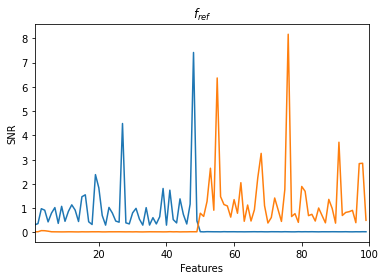

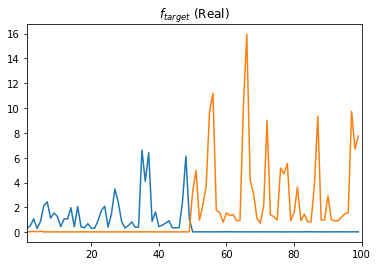

epoch: 1, batch: 99, d_loss: 1.0064098834991455, g_loss: 0.6931471228599548, real_acc: 0.9891125, fake_acc: 0.9972541666666667
epoch: 1, batch: 199, d_loss: 1.0064089894294739, g_loss: 0.6931471228599548, real_acc: 0.9906642857142857, fake_acc: 0.9976392857142857
epoch: 1, batch: 299, d_loss: 1.0106263160705566, g_loss: 0.6931471228599548, real_acc: 0.991809375, fake_acc: 0.99793125
epoch: 1, batch: 399, d_loss: 1.0064103305339813, g_loss: 0.6931471228599548, real_acc: 0.9927083333333333, fake_acc: 0.9981555555555556
epoch: 1, batch: 499, d_loss: 1.0064099729061127, g_loss: 0.6931471228599548, real_acc: 0.9934375, fake_acc: 0.9983275
epoch: 2, batch: 99, d_loss: 1.006409227848053, g_loss: 0.6931471228599548, real_acc: 0.994025, fake_acc: 0.9984772727272727
epoch: 2, batch: 199, d_loss: 1.0064088702201843, g_loss: 0.6931471228599548, real_acc: 0.9944979166666666, fake_acc: 0.9986020833333333
epoch: 2, batch: 299, d_loss: 1.0064093172550201, g_loss: 0.6931471228599548, real_acc: 0.994921

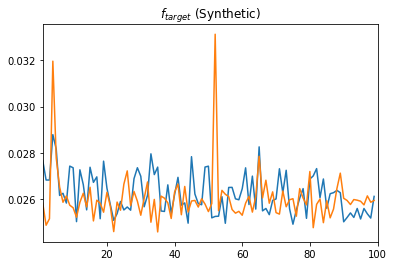

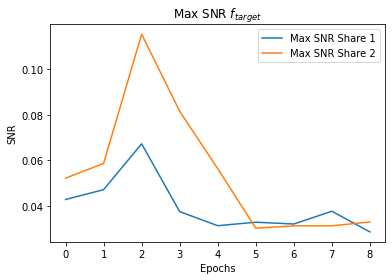

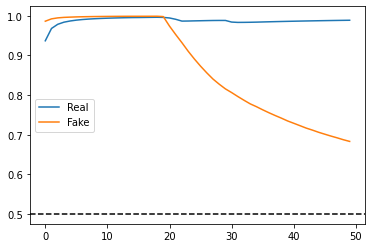

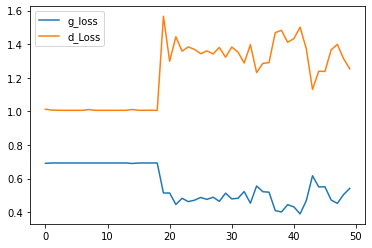

epoch: 10, batch: 99, d_loss: 1.3521226048469543, g_loss: 0.4813610911369324, real_acc: 0.9890392156862745, fake_acc: 0.6795254901960784
epoch: 10, batch: 199, d_loss: 1.1288813948631287, g_loss: 0.6181198358535767, real_acc: 0.9892475961538462, fake_acc: 0.6756442307692307
epoch: 10, batch: 299, d_loss: 1.3180163502693176, g_loss: 0.5022547245025635, real_acc: 0.989447641509434, fake_acc: 0.672097641509434
epoch: 10, batch: 399, d_loss: 1.2125969529151917, g_loss: 0.566835343837738, real_acc: 0.9896402777777777, fake_acc: 0.6684671296296296
epoch: 10, batch: 499, d_loss: 1.3397203087806702, g_loss: 0.4889587461948395, real_acc: 0.9898281818181818, fake_acc: 0.6643922727272727
epoch: 11, batch: 99, d_loss: 1.359874188899994, g_loss: 0.476612389087677, real_acc: 0.9900066964285714, fake_acc: 0.6611084821428571
epoch: 11, batch: 199, d_loss: 1.4668437838554382, g_loss: 0.4110822379589081, real_acc: 0.990180701754386, fake_acc: 0.6577197368421053
epoch: 11, batch: 299, d_loss: 1.404832303

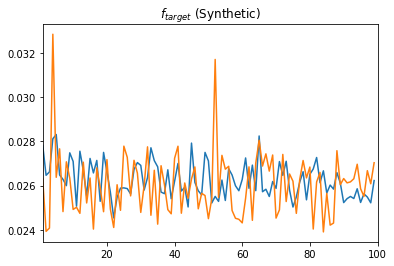

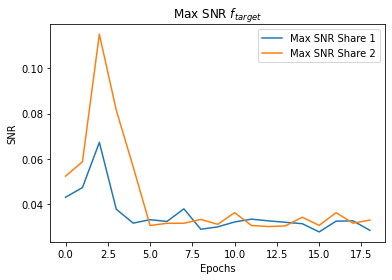

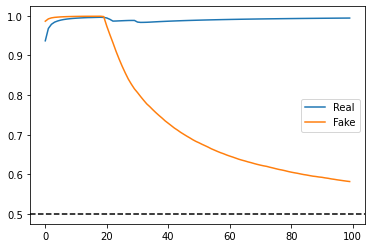

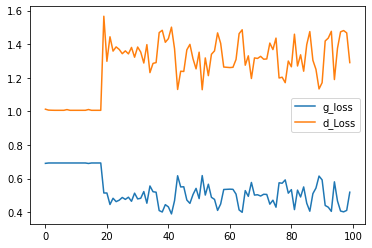

epoch: 20, batch: 99, d_loss: 1.2156975269317627, g_loss: 0.5649358630180359, real_acc: 0.9944081683168317, fake_acc: 0.5807027227722772
epoch: 20, batch: 199, d_loss: 1.2808095216751099, g_loss: 0.5250478982925415, real_acc: 0.9944622549019608, fake_acc: 0.5796267156862746
epoch: 20, batch: 299, d_loss: 1.2389516830444336, g_loss: 0.5506901741027832, real_acc: 0.9945150485436893, fake_acc: 0.5784662621359223
epoch: 20, batch: 399, d_loss: 1.1567866206169128, g_loss: 0.6010249853134155, real_acc: 0.9945665865384615, fake_acc: 0.57756875
epoch: 20, batch: 499, d_loss: 1.4714946150779724, g_loss: 0.408233106136322, real_acc: 0.9946178571428571, fake_acc: 0.5763904761904762
epoch: 21, batch: 99, d_loss: 1.2901111245155334, g_loss: 0.5193495750427246, real_acc: 0.9946669811320755, fake_acc: 0.5756301886792453
epoch: 21, batch: 199, d_loss: 1.4559916853904724, g_loss: 0.4177302122116089, real_acc: 0.9947158878504673, fake_acc: 0.5746352803738318
epoch: 21, batch: 299, d_loss: 1.277708888053

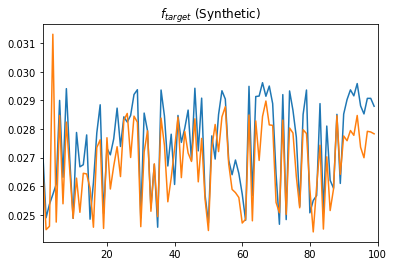

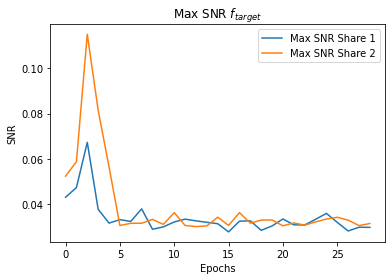

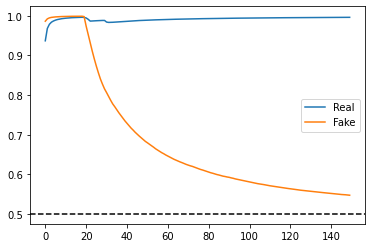

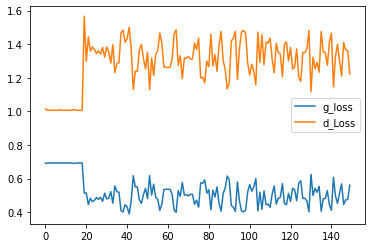

epoch: 30, batch: 99, d_loss: 1.3583237528800964, g_loss: 0.47756218910217285, real_acc: 0.9962223509933775, fake_acc: 0.5468299668874173


KeyboardInterrupt: 

In [33]:
train()